# What is going on in here?

### Necessary libraries

In [223]:
import numpy as np
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import tqdm
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from Tree import Tree
from sklearn.metrics import confusion_matrix

# graphviz PATH hotfix
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

apiKey = "RGAPI-853a3abb-2a34-47a5-b828-9bfac2936ac6"

## Teamfight Tacticts dataset

Main goal of this part is to predict that there are relations between in-game charackters and in what kind of composition, they winnability is the highest. The game is a variant od League of Legends, called Teamfight Tactits (TFT), which is turn based and non-deterministic. Players role is to compose set of characters, that beats other players compositions. Throughout the game, armies are getting bigger and characters are getting stronger. We will be covering final stage, when are units are available. Important information is, that each unit has some special traits, so collecting characters with same traits will benefit the player. Our plan is to find best combinations of 2-3 units that are the most succesful and after such classification, compare it to the traits.

Loading data, previously scrapped from RiotAPI and preprocessed.

In [194]:
with open('games.json') as games_scrapped_from_API:
    games_data = json.load(games_scrapped_from_API)

In [195]:
units3 = np.array(["", 0, 0])
for game in games_data:
    for i, squad in enumerate(game[:2]):
        for champ in squad:
            won = (i+1)%2
            units3 = np.vstack((units3,[champ[0],int(won),int(i)]))

In [196]:
units_c = pd.DataFrame(units3, columns=['Champion','Won', 'Lost'])
units_c.astype({'Won':'int32','Lost':'int32'}).dtypes
a = units_c.groupby(['Champion']).sum()

temp = np.array(a)
res = np.array([None, None])
for pair in temp:
    x = pair[0]
    y = pair[1]
    x = np.sum([int(i) for i in x])
    y = np.sum([int(i) for i in y])
    res = np.vstack((res, (x, y)))
    
formated_df = np.c_[np.array(a.index),res.T[0][1:],res.T[1][1:]]
formated_df = formated_df[1:]
units4 = pd.DataFrame(formated_df, columns=['Champion','Won', 'Lost'])
units4 = units4.sort_values(by=['Won'])

Decision Tree - algorithm taken from our earlier implementation, done for ML course. 

In [217]:
def TFT_data_preprocess(champions, data_json):
    df = pd.DataFrame(columns=champions+['target'], dtype=np.int8)
    for i, game in enumerate(data_json):
        winner, loser = game[0], game[1]
        winner_champs = [c[0] for c in winner]
        loser_champs  = [c[0] for c in loser]
        winner_row = np.empty(len(champions)+1, dtype=np.str)
        loser_row  = np.empty(len(champions)+1, dtype=np.str)
        winner_row.fill('f')
        loser_row.fill('f')
        winner_row[-1] = 1
        loser_row[-1] = 0
        for j, champion in enumerate(champions):
            if champion in winner_champs:
                winner_row[j] = 't'
            if champion in loser_champs:
                loser_row[j]  = 't'
        df.loc[2*i]   = winner_row
        df.loc[2*i+1] = loser_row
    return df
    
tft_df = TFT_data_preprocess(list(units4['Champion']), games_data)
tft_df.head()

Neeko Maokai Ivern Leblanc Veigar Diana Warwick Vayne Braum Malzahar  ...  \
0     f      f     f       f      f     f       f     f     f        f  ...   
1     f      f     f       t      f     f       f     f     f        f  ...   
2     f      f     f       f      f     f       f     f     f        f  ...   
3     f      f     f       f      f     f       f     f     f        f  ...   
4     f      f     f       f      f     f       f     f     f        f  ...   

  Qiyana Kindred Brand Nami Thresh Annie Yorick Malphite Nautilus target  
0      f       f     t    t      t     t      f        t        t      1  
1      f       f     t    f      t     f      f        t        t      0  
2      f       f     f    f      f     f      f        f        f      1  
3      f       f     f    t      f     f      f        f        f      0  
4      f       f     t    t      f     t      f        f        f      1  

[5 rows x 53 columns]

In [216]:
train = tft_df.sample(frac=0.8)
test  = tft_df.drop(train.index)
X_train = train.drop('target', axis=1)
X_test  =  test.drop('target', axis=1)
Y_train = train.target
Y_test  =  test.target

In [220]:
tft_tree = Tree(train)

In [228]:
tft_tree.draw()

In [225]:
Y_predict = [tft_tree.classify(X_test.iloc[i]) for i in range(len(X_test))]
Y_predict = pd.Series(Y_predict)
Y_predict.index = Y_test.index
TFT_score = Y_predict==Y_test
# TFT_score.value_counts()

Confusion matrix tells the story.

In [227]:
confusion_matrix(Y_test, Y_predict)

array([[370, 363],
       [378, 329]], dtype=int64)

In [197]:
# plt.subplots(figsize=(16,9))
# sns.barplot(x='Champion',y='Won', data=units4)
# plt.xticks(rotation=90)
# plt.show()

Decision trees did not succeed because we picked the best players, that expliot game strategies to the maximum. In this case, they are all playing currently the best champions and diferences between winners and loosers are to small to predict anything.

That observation can be seen on the plot below.

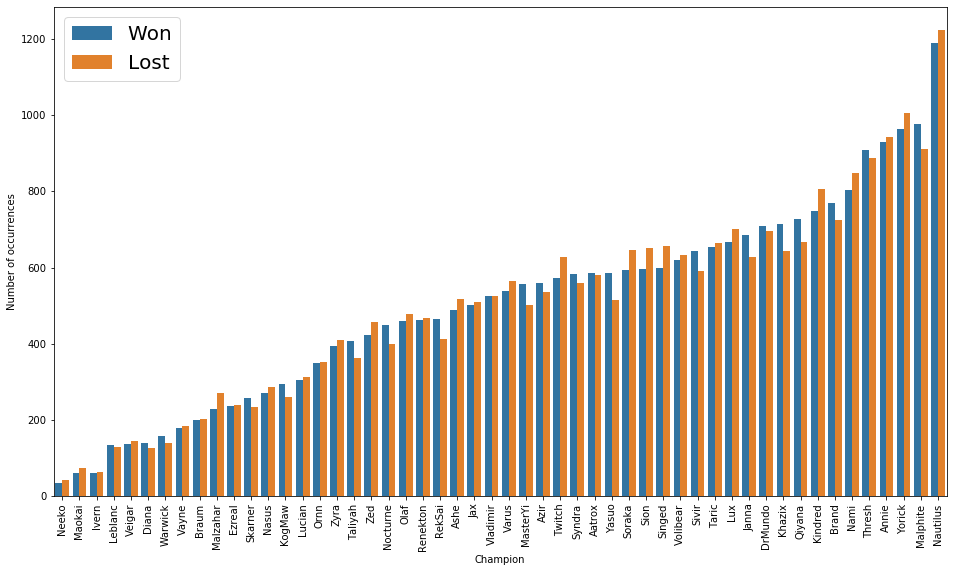

In [198]:
plt.subplots(figsize=(16,9))
units_melted = pd.melt(units4, id_vars=units4.columns[0], var_name="Verdict", value_name="Number of occurrences")
sns.barplot(x=units4.columns[0], y="Number of occurrences", hue="Verdict", data=units_melted)
plt.xticks(rotation=90)
plt.legend(loc=2, prop={'size': 20})
plt.show()

In [229]:

units_to_arr = np.array(units4)
units_wl = np.array([str(units_to_arr[0][0]), np.round(int(units_to_arr[0][1])/(int(units_to_arr[0][1]) + int(units_to_arr[0][2]))*100, 2)])
units_to_arr = np.array(units4)[1:]

for i in range(len(units_to_arr)):
    units_wl = np.vstack((units_wl, [str(units_to_arr[i][0]), np.round(int(units_to_arr[i][1])/(int(units_to_arr[i][1]) + int(units_to_arr[i][2]))*100, 2)]))

units_wl_df = pd.DataFrame(units_wl, columns=['Champion','Winratio'])

In [230]:
units_wl_df['Winratio'] = units_wl_df['Winratio'].apply(pd.to_numeric, errors='coerce')
units_wl_df = units_wl_df.sort_values(by=['Winratio'])

Win ratio also proves that statement. There are none overpowered champions, which implies that there are also none superior combionations of them.

We are not able to provide any breaking results, but at leasts we've proven, that game is pretty balanced.

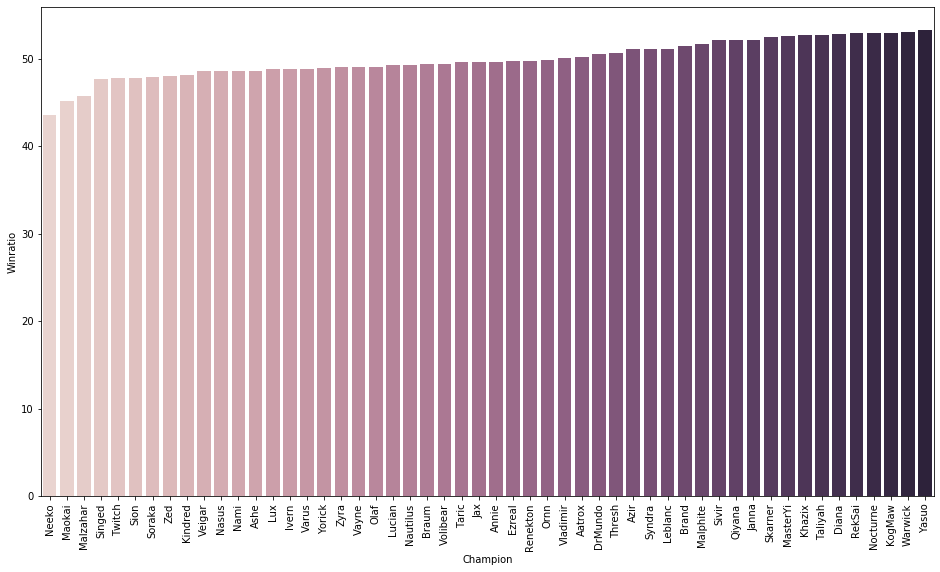

In [231]:
plt.subplots(figsize=(16,9))
sns.barplot(x='Champion',y='Winratio', data=units_wl_df, palette=sns.cubehelix_palette(len(units_wl_df.index)))
plt.xticks(rotation=90)
plt.show()